## Model Predictions
Generating STA's and GQM's ith model predictions

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
# Load RF center and cell key
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5' #'data/cloud_data_stim_dim80_robs_sqrad_0.1.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
L4_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))
print('L4 cells:', len(L4_idx))

LGN cells: 214
V1 cells: 1491
L4 cells: 794


In [4]:
L4_cell_key = [cell_key[i] for i in L4_idx]
L4_exc_idx = [i for i, val in enumerate(L4_cell_key) if val == 'V1_Exc_L4']
L4_inh_idx = [i for i, val in enumerate(L4_cell_key) if val == 'V1_Inh_L4']

In [5]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=L4_idx, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 50.75049042701721 sec


In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data[0]['robs'].shape[1]
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 794
Number of time points 510000


In [7]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[L4_idx], y_pos[L4_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (794, 2)


## Load Model

In [8]:
cnn = NDN.load_model_zip('models/1004_three_layer_model_ORICONV_CNN_L4_timeshiftlayer.ndn')
cnn.block_sample = True
cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3971, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])
      Qmu: torch.Size([794, 1])
      Qsigma: torch.Size([794, 1])


In [9]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:18<00:00,  1.87it/s]

Log Likelyhood shape (794,)


L4 Exc Mean LL: 0.6054565 L4 Inh Mean LL: 0.49869812


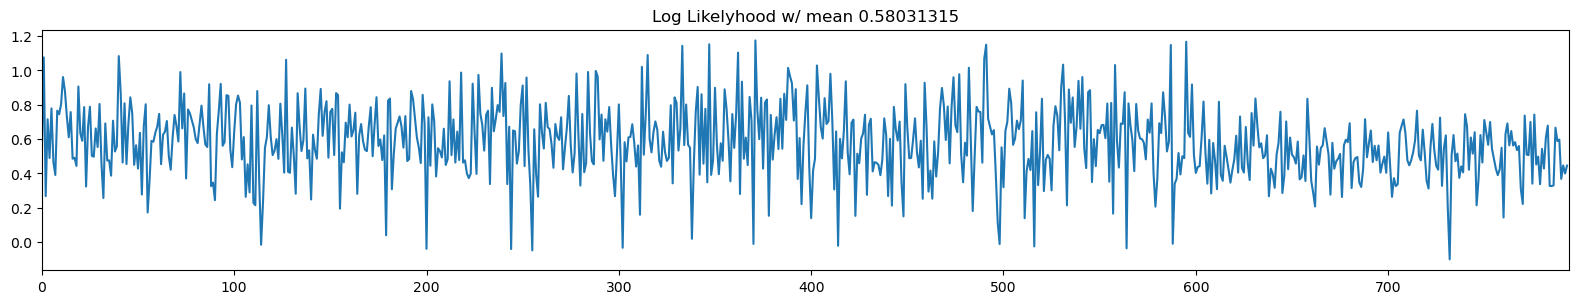

In [10]:
print('L4 Exc Mean LL:', np.mean(LL[L4_exc_idx]), 'L4 Inh Mean LL:', np.mean(LL[L4_inh_idx]))
ss()
plt.plot(LL)
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL)))
plt.xlim([0,NC])
plt.show()

## Generate Prediction

In [11]:
pred_data = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                         'robs': data[data.val_blks]['robs'], 
                         'dfs':data[data.val_blks]['dfs']}, device=device)

In [12]:
N_blocks = data.val_blks.shape[0]
block_len = data.block_len
val_NT = N_blocks*block_len
print('Number of blocks:', N_blocks)
print('Block length:', block_len)
print('Total number of time points:',val_NT)

Number of blocks: 102
Block length: 1000
Total number of time points: 102000


In [13]:
preds = np.zeros((val_NT, NC))
for i in range(N_blocks):
    start = i*block_len
    end   = (i*block_len)+block_len
    cnn.to(device)
    preds[start:end,:] = cnn(pred_data[start:end]).detach().cpu().numpy()
    cnn.to(device0)
    print('Block', i, 'complete')

Block 0 complete
Block 1 complete
Block 2 complete
Block 3 complete
Block 4 complete
Block 5 complete
Block 6 complete
Block 7 complete
Block 8 complete
Block 9 complete
Block 10 complete
Block 11 complete
Block 12 complete
Block 13 complete
Block 14 complete
Block 15 complete
Block 16 complete
Block 17 complete
Block 18 complete
Block 19 complete
Block 20 complete
Block 21 complete
Block 22 complete
Block 23 complete
Block 24 complete
Block 25 complete
Block 26 complete
Block 27 complete
Block 28 complete
Block 29 complete
Block 30 complete
Block 31 complete
Block 32 complete
Block 33 complete
Block 34 complete
Block 35 complete
Block 36 complete
Block 37 complete
Block 38 complete
Block 39 complete
Block 40 complete
Block 41 complete
Block 42 complete
Block 43 complete
Block 44 complete
Block 45 complete
Block 46 complete
Block 47 complete
Block 48 complete
Block 49 complete
Block 50 complete
Block 51 complete
Block 52 complete
Block 53 complete
Block 54 complete
Block 55 complete
Bl

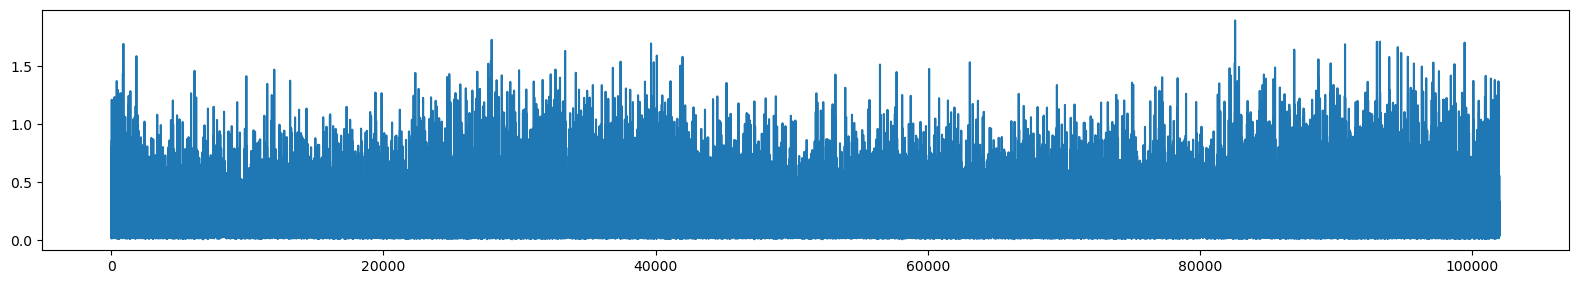

In [15]:
ss()
plt.plot(preds[:,0])

In [14]:
pred_data = None

## STA

### Predicted

In [18]:
pred_robs = torch.tensor(preds, dtype=torch.float32)*data[data.val_blks]['dfs']
pred_nspks = torch.sum(pred_robs,axis=0)

In [21]:
n_lags = 5
pred_sta_arr = np.zeros((n_lags,L,L,NC))
for j in range(n_lags):
    if j == 0:
        sta = (data[data.val_blks]['stim'].T @ pred_robs)
    else:
        sta = (data[data.val_blks]['stim'][:-j, ...].T @ pred_robs[j:,:])
    pred_sta_arr[j,:,:,:] = (sta/pred_nspks).reshape([L,L,NC]).numpy() 
    print('Completed lag', j)

Completed lag 0
Completed lag 1
Completed lag 2
Completed lag 3
Completed lag 4


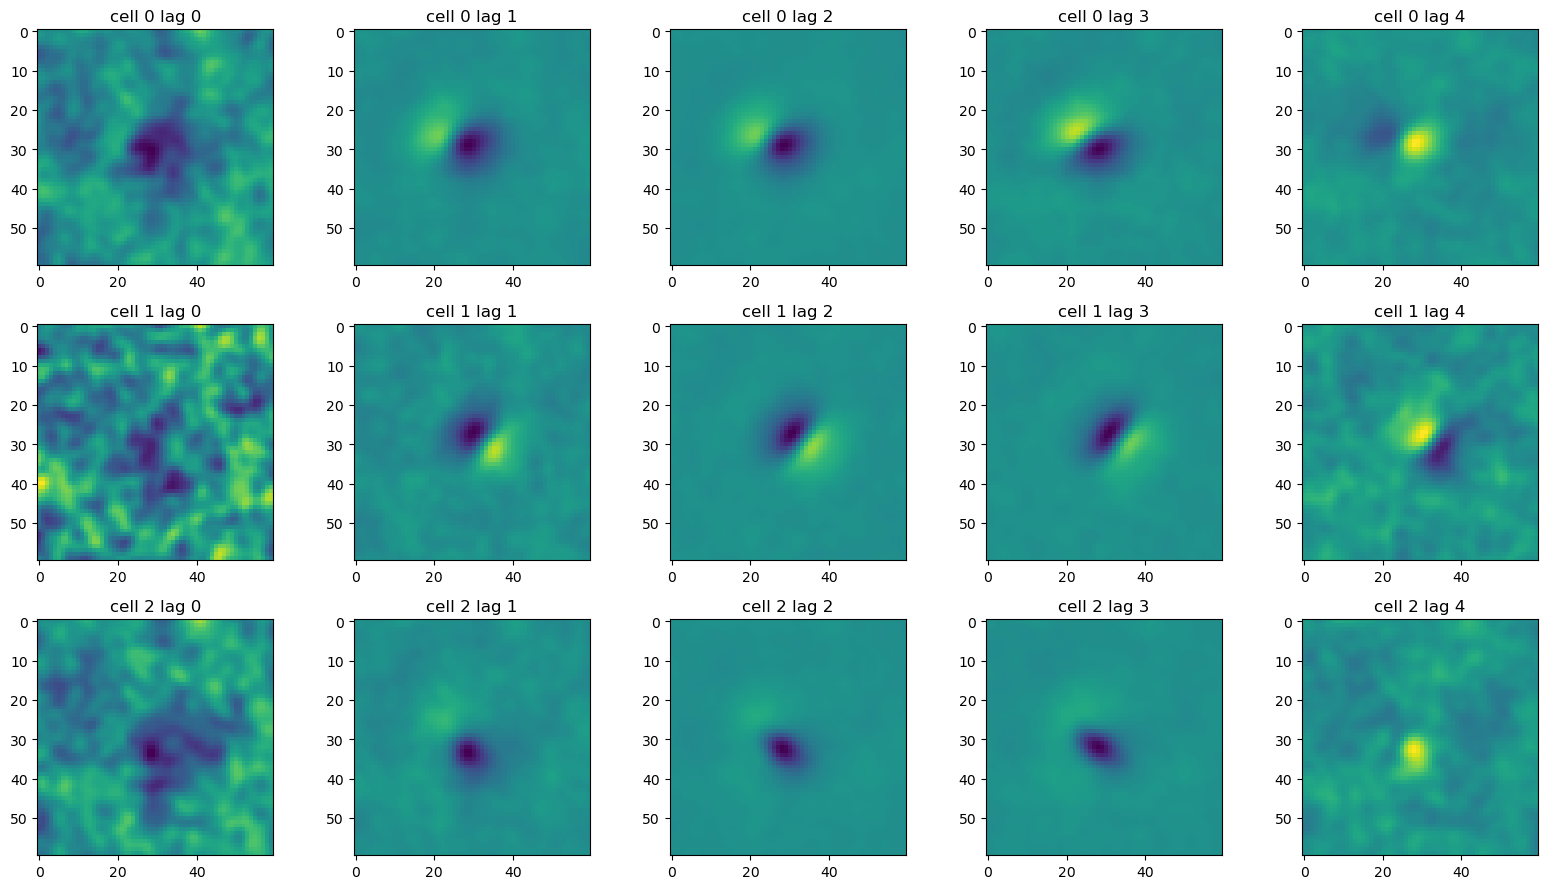

In [23]:
cc = 3
ss(cc,n_lags)
k = 1
for i in range(cc):
    for j in range(n_lags):
        plt.subplot(cc,n_lags,k)
        l = L4_exc_idx[i]
        imagesc(pred_sta_arr[j,:,:,l])
        plt.title('cell '+str(l)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

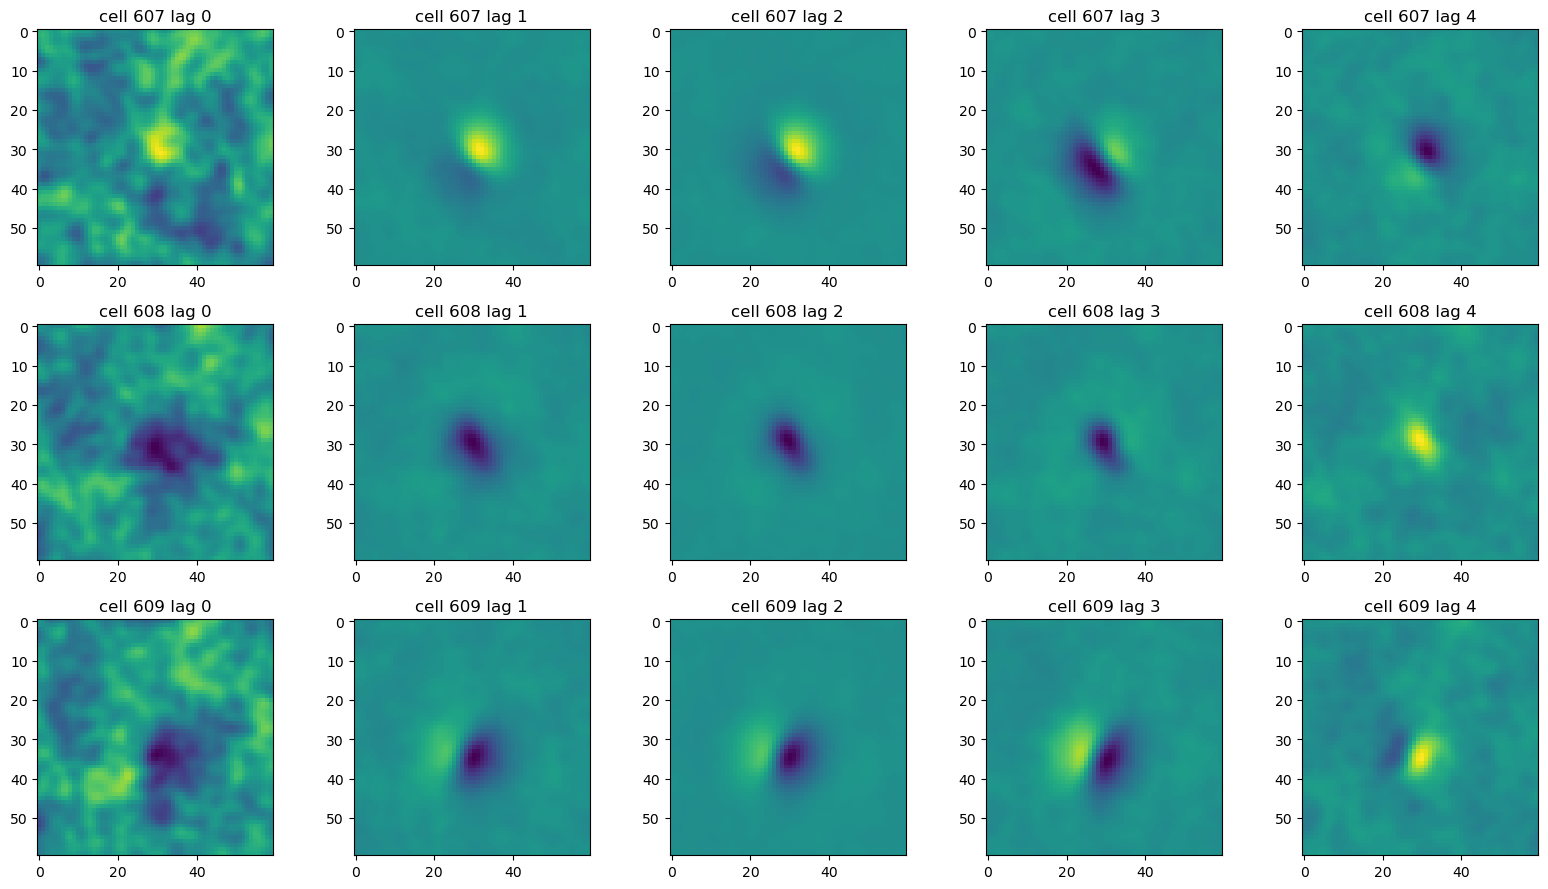

In [24]:
cc = 3
ss(cc,n_lags)
k = 1
for i in range(cc):
    for j in range(n_lags):
        plt.subplot(cc,n_lags,k)
        l = L4_inh_idx[i]
        imagesc(pred_sta_arr[j,:,:,l])
        plt.title('cell '+str(l)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

### True

In [25]:
true_robs = data[data.val_blks]['robs']*data[data.val_blks]['dfs']
true_nspks = torch.sum(true_robs,axis=0)

In [26]:
true_sta_arr = np.zeros((n_lags,L,L,NC))
for j in range(n_lags):
    if j == 0:
        sta = (data[data.val_blks]['stim'].T @ true_robs)
    else:
        sta = (data[data.val_blks]['stim'][:-j, ...].T @ true_robs[j:,:])
    true_sta_arr[j,:,:,:] = (sta/true_nspks).reshape([L,L,NC]).numpy() 
    print('Completed lag', j)

Completed lag 0
Completed lag 1
Completed lag 2
Completed lag 3
Completed lag 4


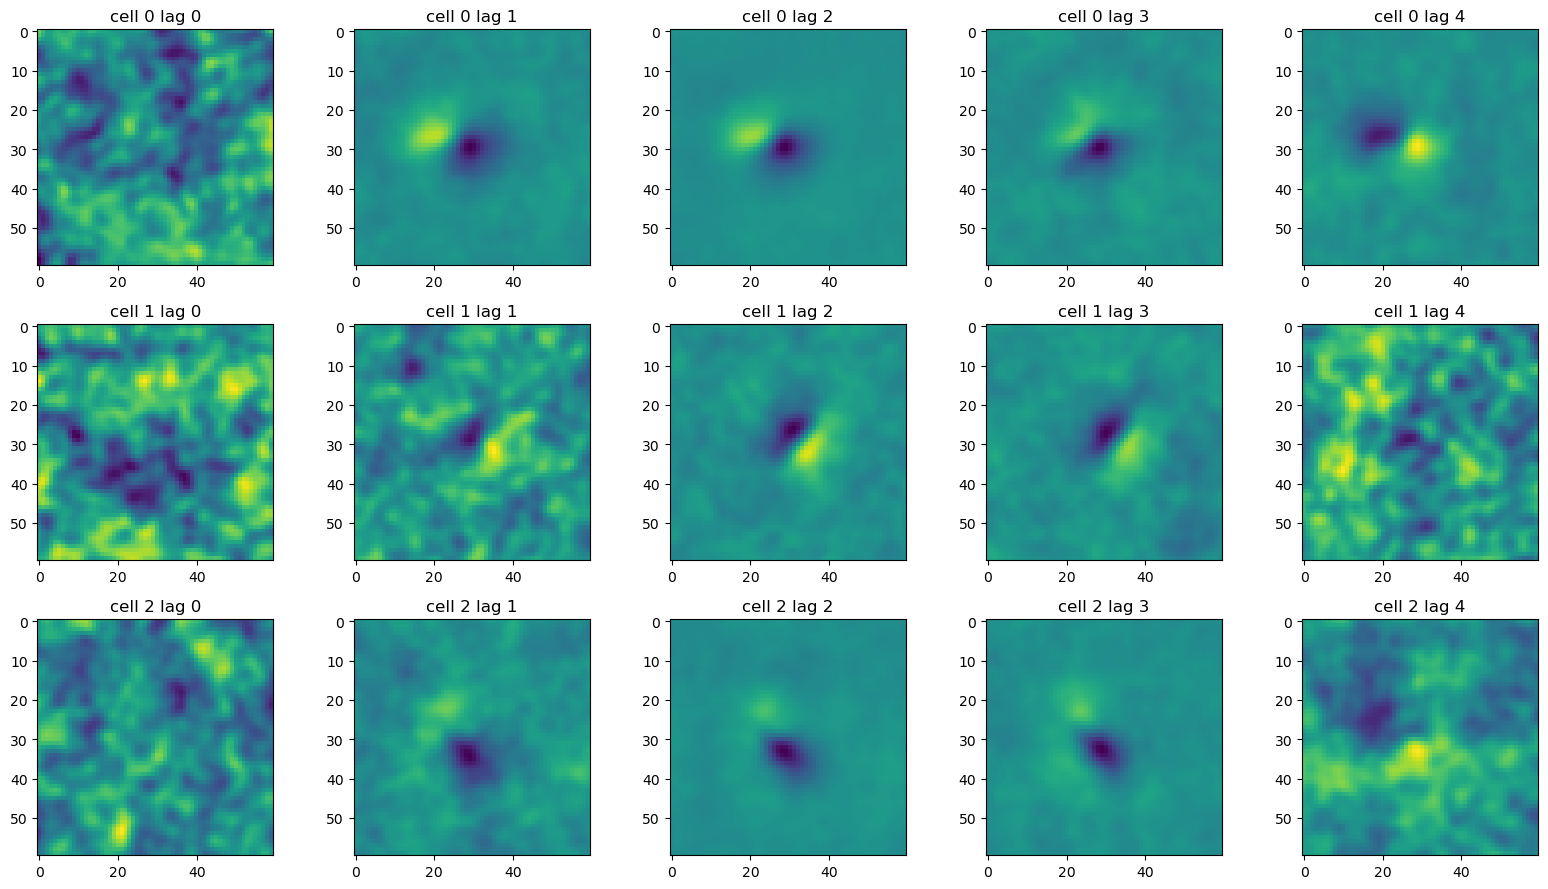

In [27]:
cc = 3
ss(cc,n_lags)
k = 1
for i in range(cc):
    for j in range(n_lags):
        plt.subplot(cc,n_lags,k)
        l = L4_exc_idx[i]
        imagesc(true_sta_arr[j,:,:,l])
        plt.title('cell '+str(l)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

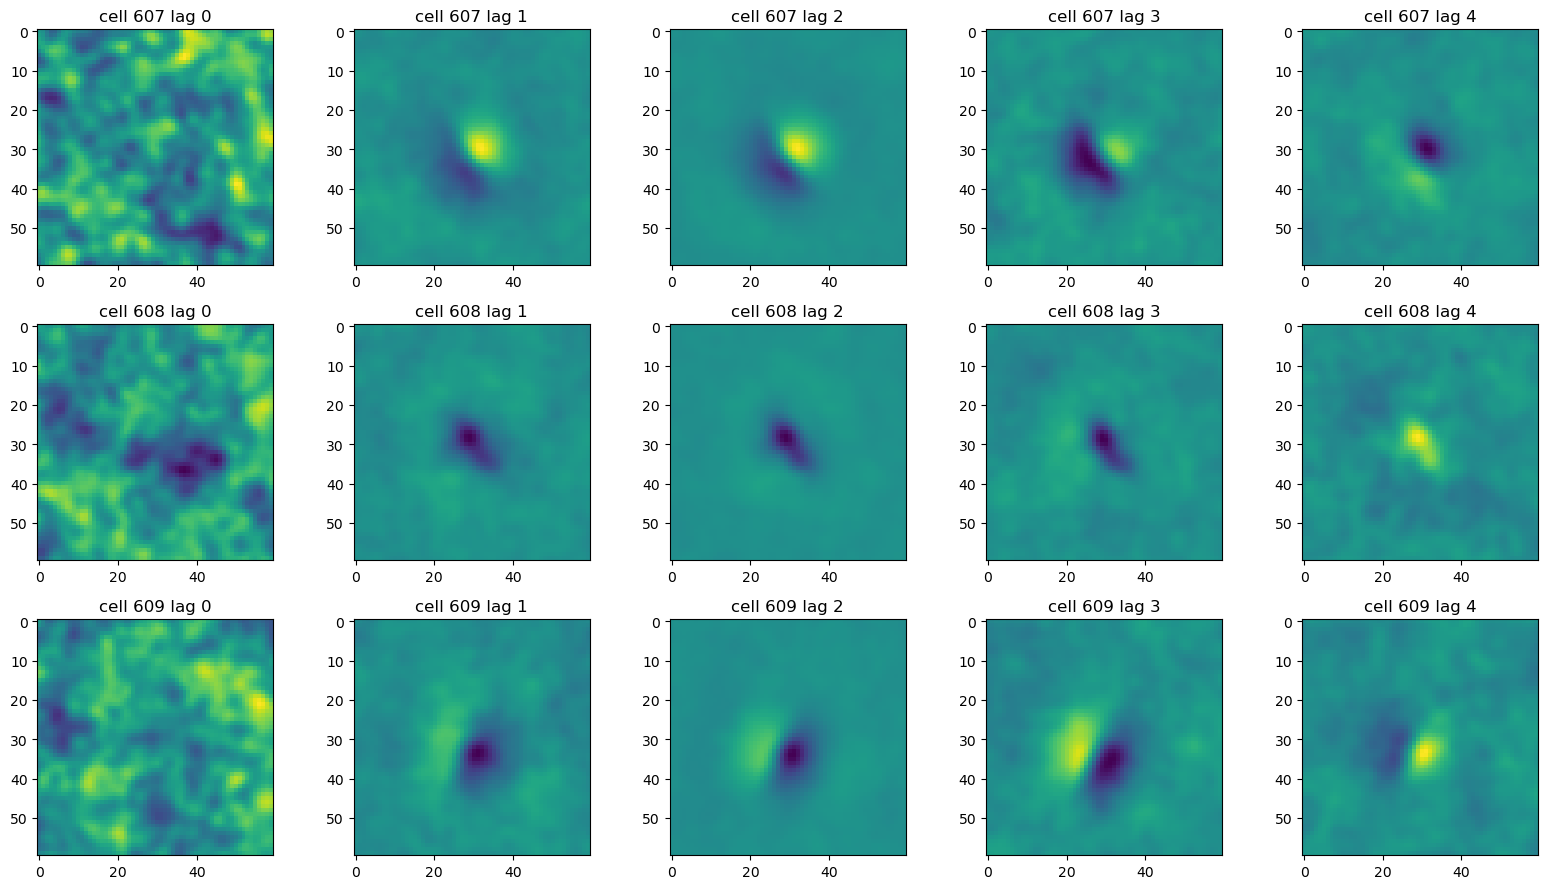

In [28]:
cc = 3
ss(cc,n_lags)
k = 1
for i in range(cc):
    for j in range(n_lags):
        plt.subplot(cc,n_lags,k)
        l = L4_inh_idx[i]
        imagesc(true_sta_arr[j,:,:,l])
        plt.title('cell '+str(l)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

### Compare the two

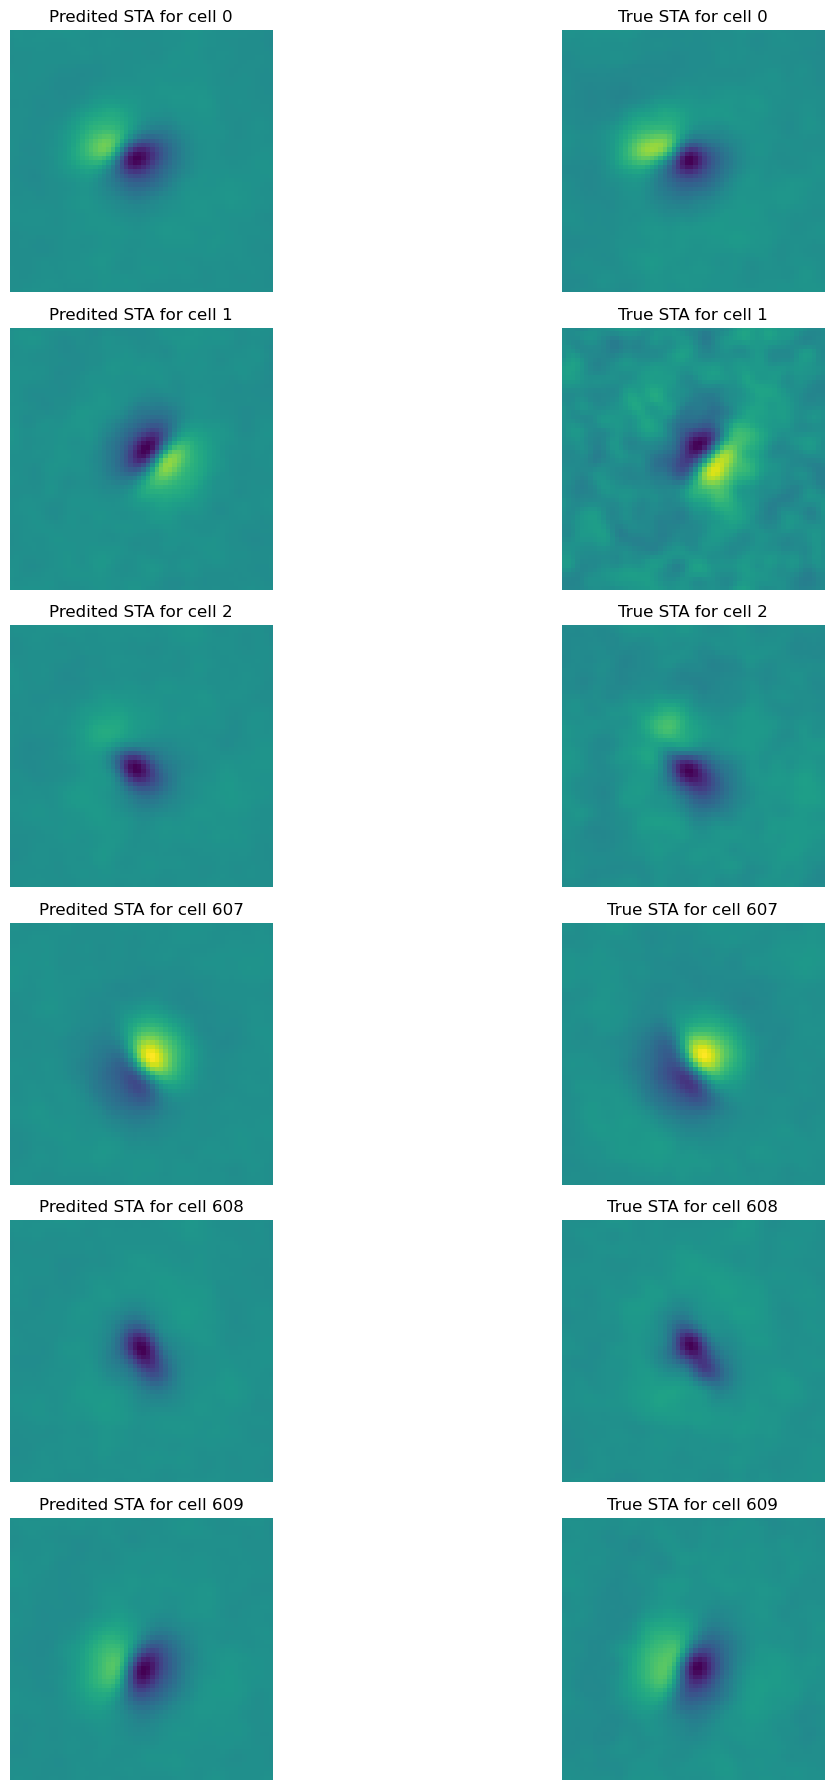

In [29]:
ss(6,2)
k = 1
for i in range(3):
    l = L4_exc_idx[i]
    plt.subplot(6,2,k)
    imagesc(pred_sta_arr[2,:,:,l])
    plt.title('Predited STA for cell '+str(l))
    plt.axis('off')
    k += 1

    plt.subplot(6,2,k)
    imagesc(true_sta_arr[2,:,:,l])
    plt.title('True STA for cell '+str(l))
    plt.axis('off')
    k += 1

for i in range(3):
    l = L4_inh_idx[i]
    plt.subplot(6,2,k)
    imagesc(pred_sta_arr[2,:,:,l])
    plt.title('Predited STA for cell '+str(l))
    plt.axis('off')
    k += 1

    plt.subplot(6,2,k)
    imagesc(true_sta_arr[2,:,:,l])
    plt.title('True STA for cell '+str(l))
    plt.axis('off')
    k += 1
    
plt.tight_layout()
plt.show()

## GQM

In [15]:
Treg = 1
XregL, XregQ = 10000.0, 10.0
LOCregL, LOCregQ = 10.0, 1000.0
L1regL, L1regQ = 1.0, None

# linear layer
glm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=1, bias=False, norm_type=0, 
    NLtype='lin', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': XregL, 'd2t': Treg, 'l1': L1regL, 'glocalx': LOCregL,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# quadratic layer
gqm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=2, bias=False, norm_type=0, 
    NLtype='square', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': XregQ, 'd2t': Treg, 'l1': L1regQ, 'glocalx': LOCregQ,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# set up linear and quadratic network
lin_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [glm_layer] )
quad_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [gqm_layer] )

# NDN layer that combines quadratic and linear layer
comb_layer = NDNLayer.layer_dict( num_filters=1, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

# set up combination network
comb_net = FFnetwork.ffnet_dict( xstim_n=None, ffnet_n=[0,1], layer_list=[comb_layer])

### Predicted

In [16]:
gqms = []
for ii in range(3):
    i = L4_exc_idx[ii]
    gdata = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                         'robs': torch.tensor(preds[:,i], dtype=torch.float32), 
                         'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)

    
    gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata[:], verbose=False)
    gqm = gqm.to(device0)
    gqms.append(gqm)
    print('Cell', i, 'GQM complete')

    gdata = None
    
for ii in range(3):
    i = L4_inh_idx[ii]
    gdata = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                         'robs': torch.tensor(preds[:,i], dtype=torch.float32), 
                         'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)

    
    gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, gdata[:], verbose=False)
    gqm = gqm.to(device0)
    gqms.append(gqm)
    print('Cell', i, 'GQM complete')

    gdata = None

Cell 0 GQM complete
Cell 1 GQM complete
Cell 2 GQM complete
Cell 607 GQM complete
Cell 608 GQM complete
Cell 609 GQM complete


In [17]:
gqms[0].get_weights(ffnet_target=0).shape

(60, 60, 11, 1)

In [18]:
gqms[0].get_weights(ffnet_target=1).shape

(60, 60, 11, 2)

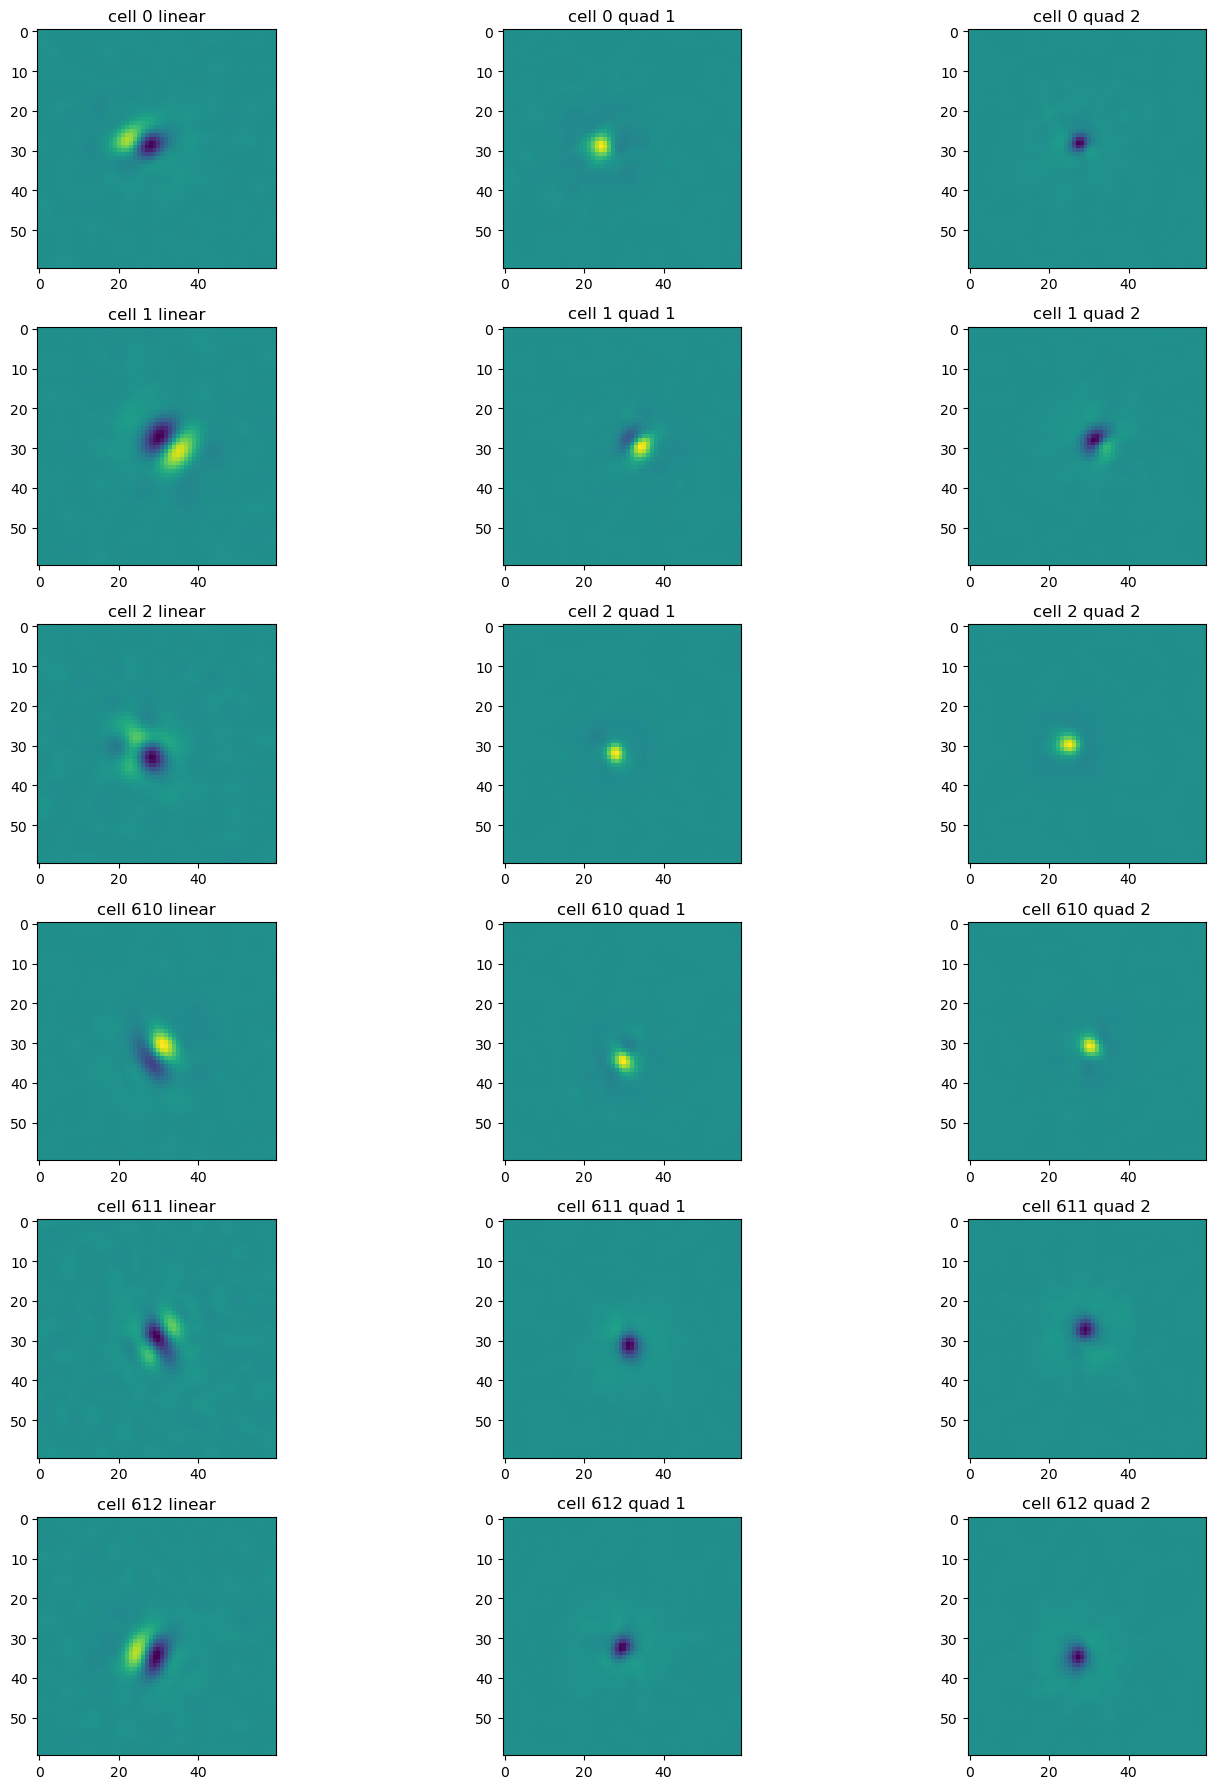

In [22]:
ss(6,3)
k = 1
for i in range(6):
    if i < 3:
        l = L4_exc_idx[i]
    else:
        l = L4_inh_idx[i]
    
    plt.subplot(6,3,k)
    imagesc(gqms[i].get_weights(ffnet_target=0)[:,:,-2,0])
    plt.title('cell '+str(l)+' linear')
    k += 1

    plt.subplot(6,3,k)
    imagesc(gqms[i].get_weights(ffnet_target=1)[:,:,-2,0])
    plt.title('cell '+str(l)+' quad 1')
    k += 1
    
    plt.subplot(6,3,k)
    imagesc(gqms[i].get_weights(ffnet_target=1)[:,:,-2,1])
    plt.title('cell '+str(l)+' quad 2')
    k += 1
plt.tight_layout()
plt.show()

### True